### Creates scenarios based on node count of inp file EPANET.
    
This example contains:
* Load a network.
* Create scenario parameters.
* Create Multiple Scenarios.
* Set quality type.
* Run Scenarios.
* Get computed quality time series.
* Plot Quality VS Time.
* Unload library

In [1]:
import random
import os 
os.chdir("../../")
from epyt import epanet

# Load network
d = epanet('Net1.inp')

EPANET version 20200 loaded (EPyT version 0.0.1).
Input File Net1.inp loaded successfully.



In [2]:
# Add uncertainty function
def add_unc(ext, unc):
    # Add uncertainty (unc) to the parameter ext
    ql = [i - unc * i for i in ext]
    qu = [i + unc * i for i in ext]
    rand_list = d.to_array([random.uniform(0, 1) for i in range(len(ext))])
    diff = d.to_array(qu) - d.to_array(ql)
    return d.to_array(ql) + d.multiply_elements(diff, rand_list)

In [ ]:
# Create scenario parameters
# Times
duration = 48
patern_time_step = 3600  # in seconds
d.setTimeSimulationDuration(duration * 3600)

# Contamintant
source_injection_rate = 10  # mg/L (Concentration), instead of mg/minute
source_injection_times = [5, 20]  # from...to in hours

# Uncertainty
qunc = 0.05

# Set quality type & units
quality_type = 'chem'
quality_units = 'mg/L'
d.setQualityType(quality_type, quality_units)

print(f'Number of Scenarios = NodeCount: {str(d.getNodeCount())}')

# Create Multiple Scenarios
# Create a scenario for each node of the net
CN = {}
for n in d.getNodeIndex():
    print(f'Scenario: {str(n)}')
    Diameters = add_unc(d.getLinkDiameter(), qunc)
    Lengths = add_unc(d.getLinkLength(), qunc)
    Roughness = add_unc(d.getLinkRoughnessCoeff(), qunc)
    Elevation = add_unc(d.getNodeElevations(), qunc)
    BaseDemand = add_unc(d.getNodeBaseDemands()[1], qunc)
    tmpPat = d.Pattern
    for multipat in tmpPat:
        Pattern = add_unc(multipat, qunc)

    # Update parameters
    d.setLinkDiameter(Diameters)
    d.setLinkLength(Lengths)
    d.setLinkRoughnessCoeff(Roughness)
    d.setNodeElevations(Elevation)
    d.setNodeBaseDemands(list(BaseDemand))
    d.setPatternMatrix(d.to_mat(Pattern))
    d.setTimeQualityStep(patern_time_step)

    zeroNodes = [0] * d.getNodeCount()
    d.setNodeInitialQuality(zeroNodes)
    d.setLinkBulkReactionCoeff([0] * d.getLinkCount())
    d.setLinkWallReactionCoeff([0] * d.getLinkCount())
    patlen = duration * 3600 / patern_time_step

    # Add pattern
    tmppat = [0] * int(patlen)
    tmpstartstep = source_injection_times[0]
    tmpendstep = source_injection_times[1]
    tmppat[tmpstartstep:tmpendstep] = [1] * (tmpendstep - tmpstartstep)
    tmp1 = d.addPattern('CONTAMINANT' + str(n), tmppat)
    tmpinjloc = n  # index of node
    tmp2 = zeroNodes

    tmp2[tmpinjloc - 1] = tmp1
    d.setNodeSourceType(tmpinjloc, 'SETPOINT')
    d.setNodeSourcePatternIndex(tmp2)
    tmp2 = zeroNodes
    tmp2[tmpinjloc - 1] = source_injection_rate
    d.setNodeSourceQuality(tmp2)

    # Get computed quality time series
    res = d.getComputedQualityTimeSeries()
    CN[n] = res.NodeQuality
    


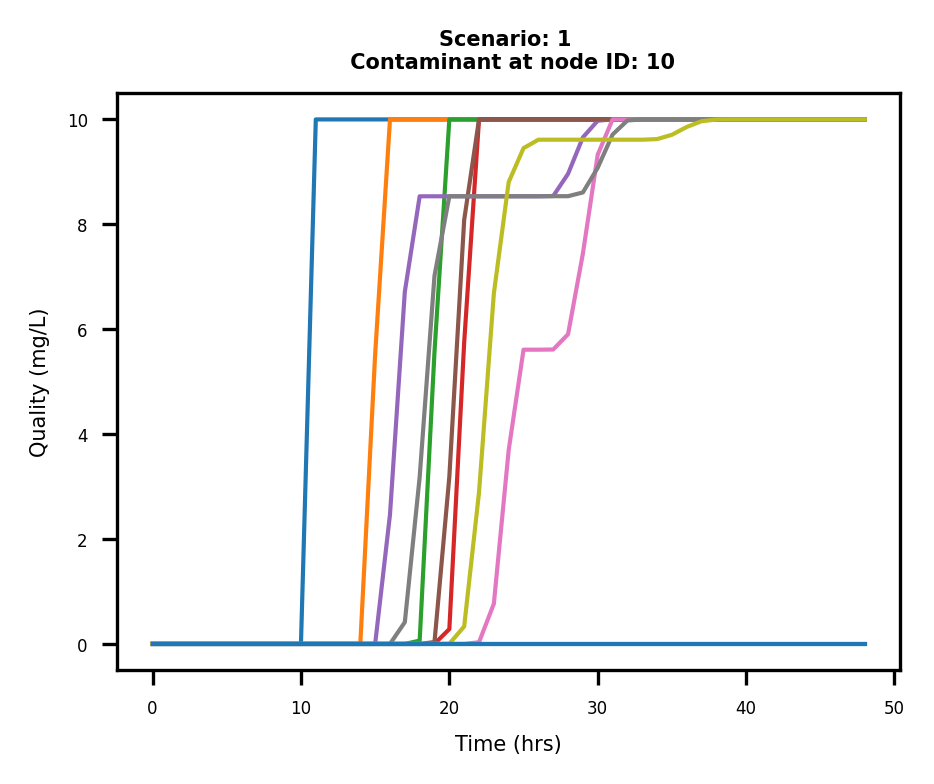

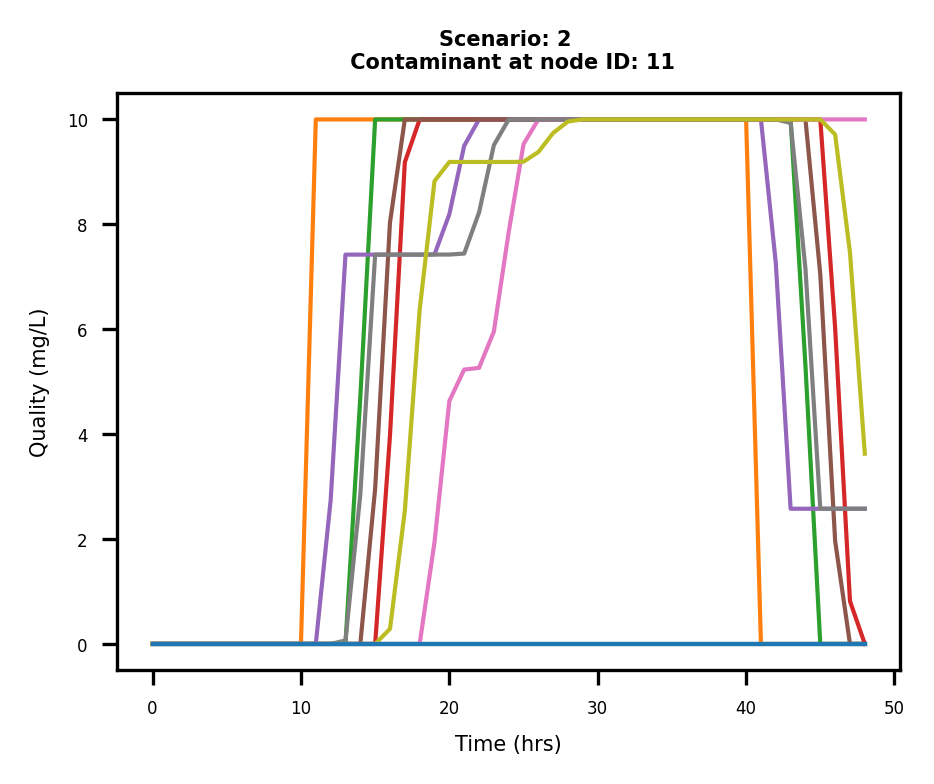

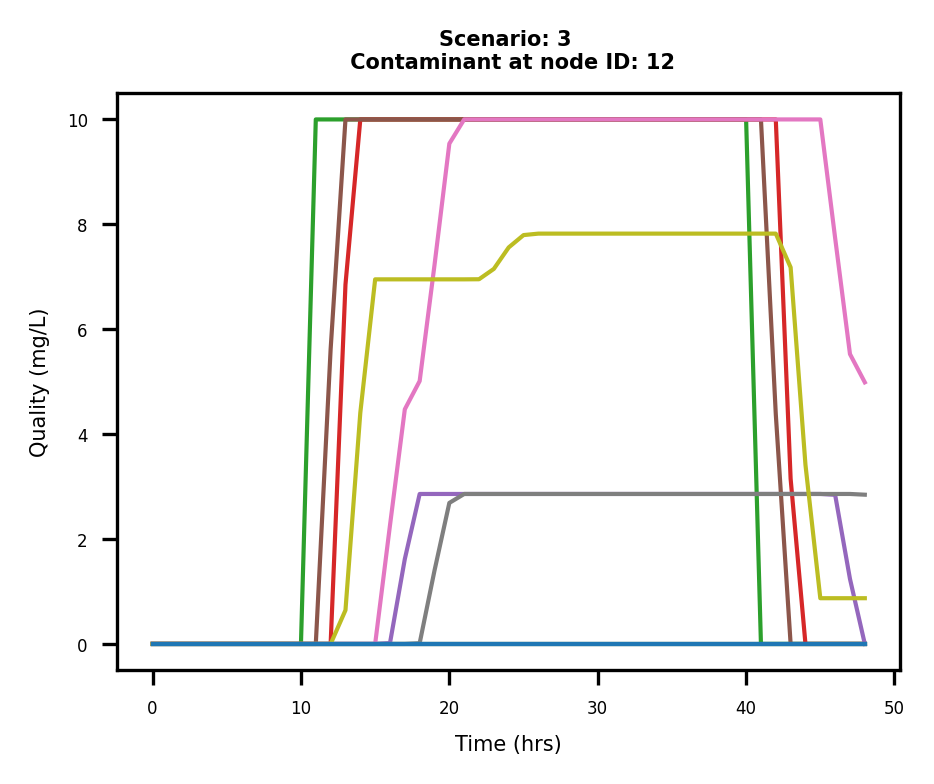

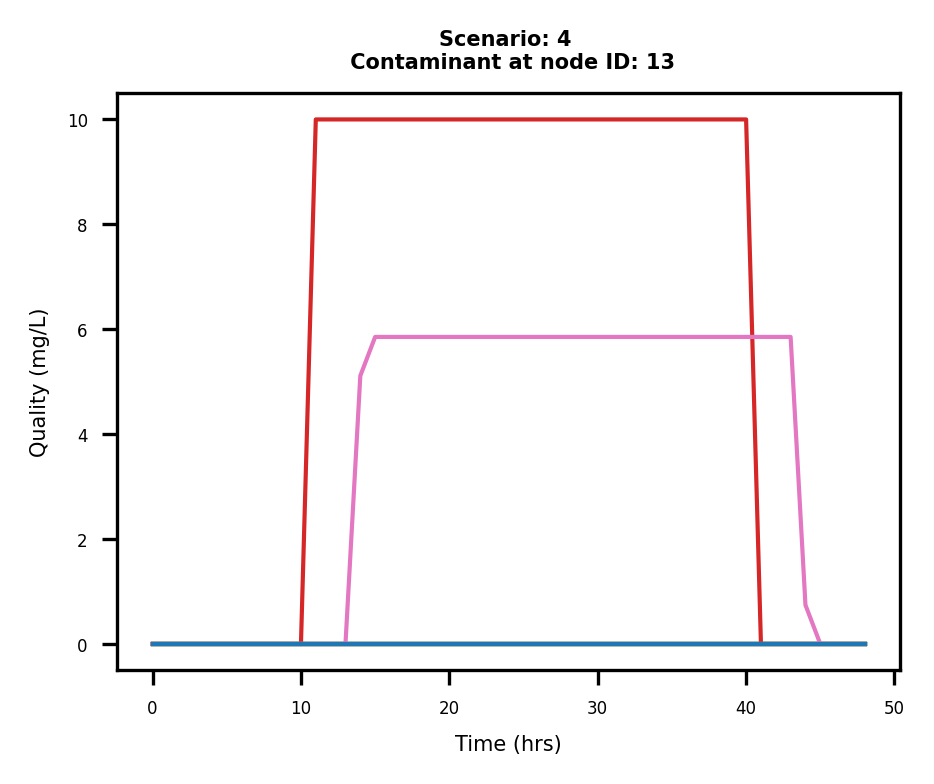

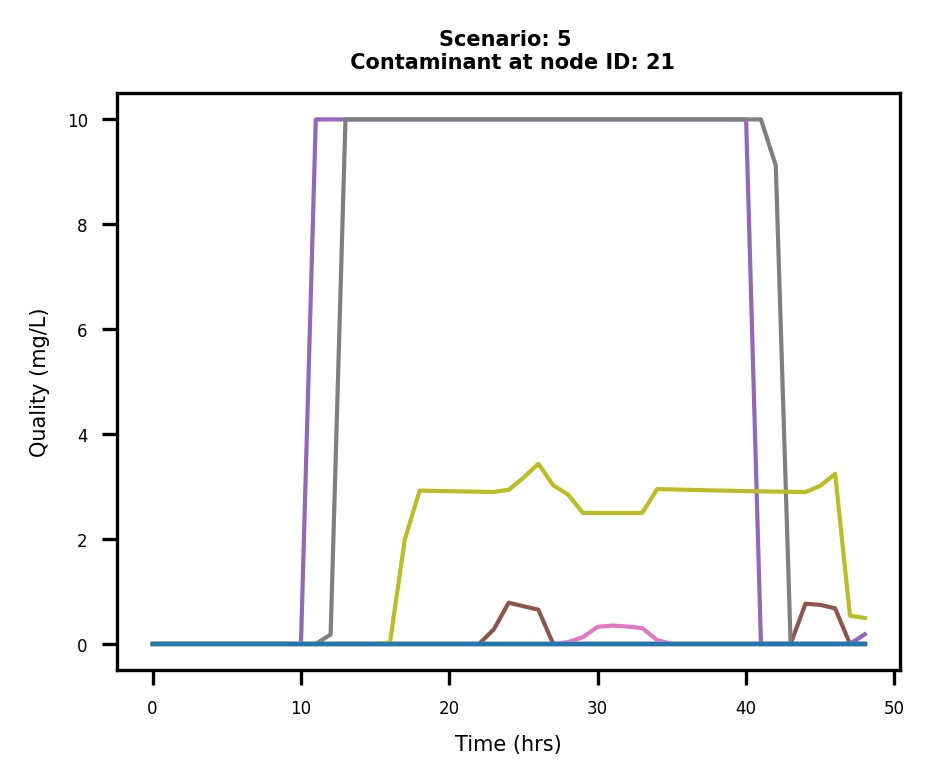

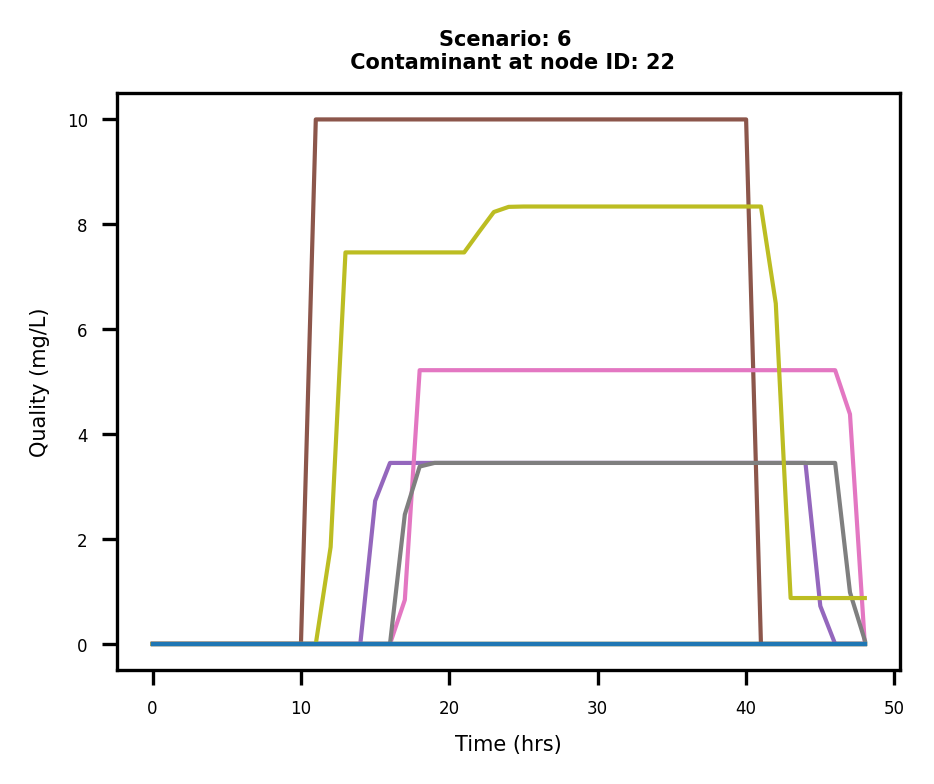

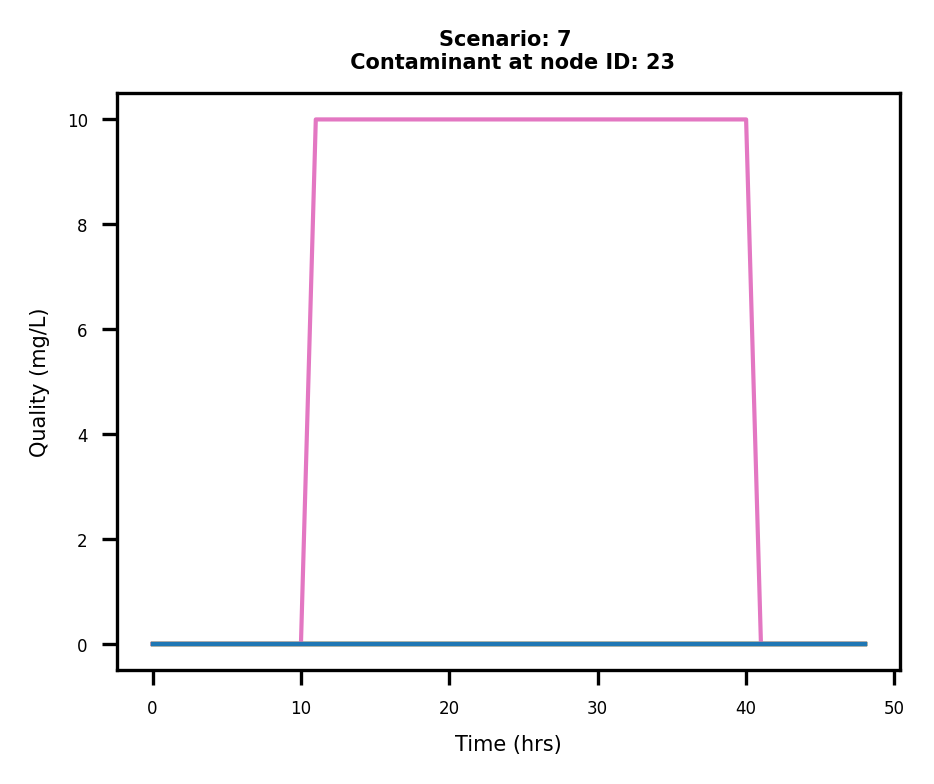

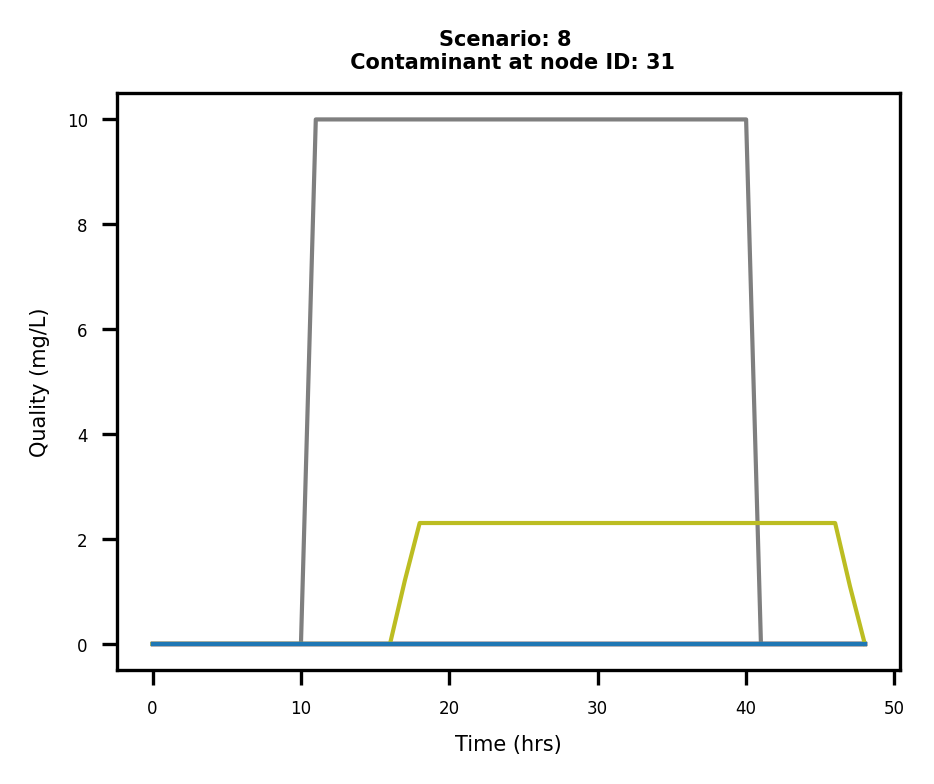

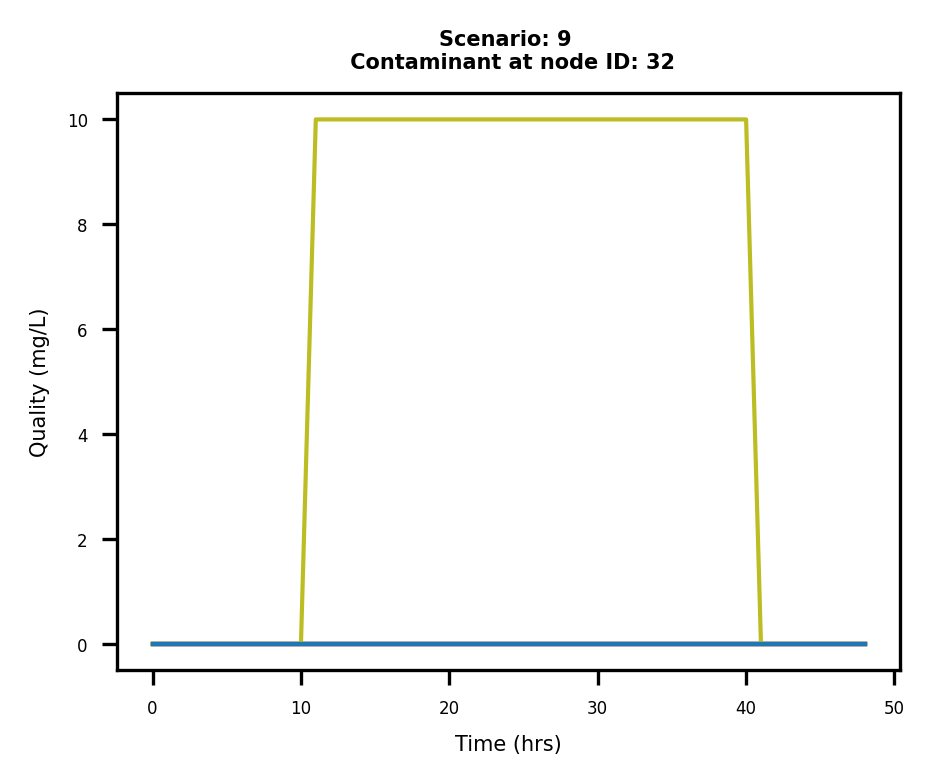

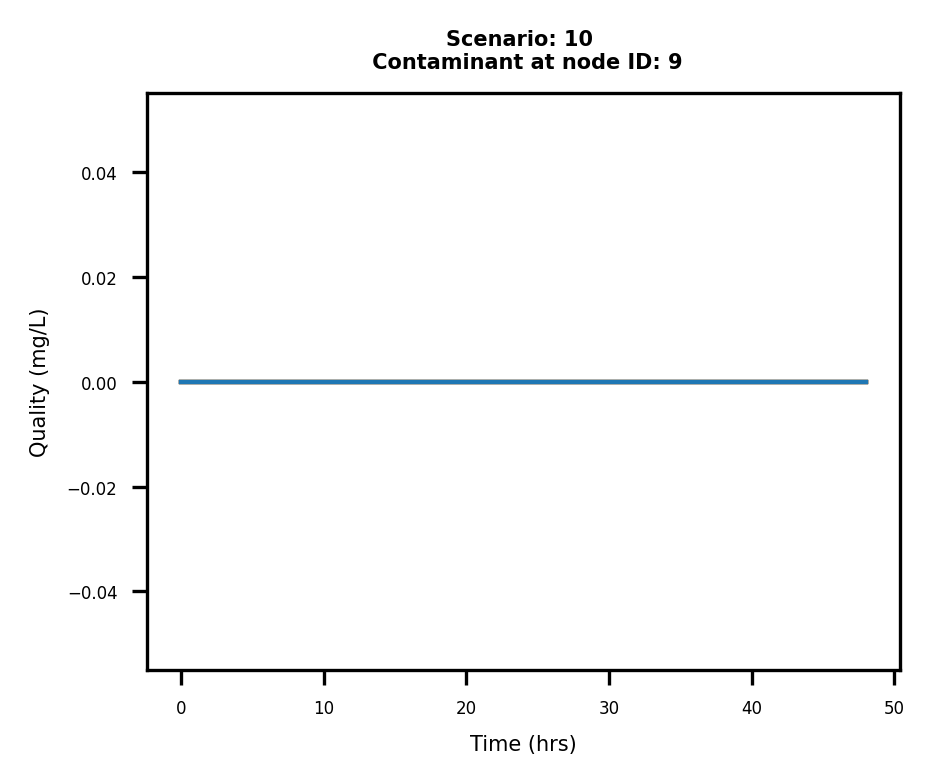

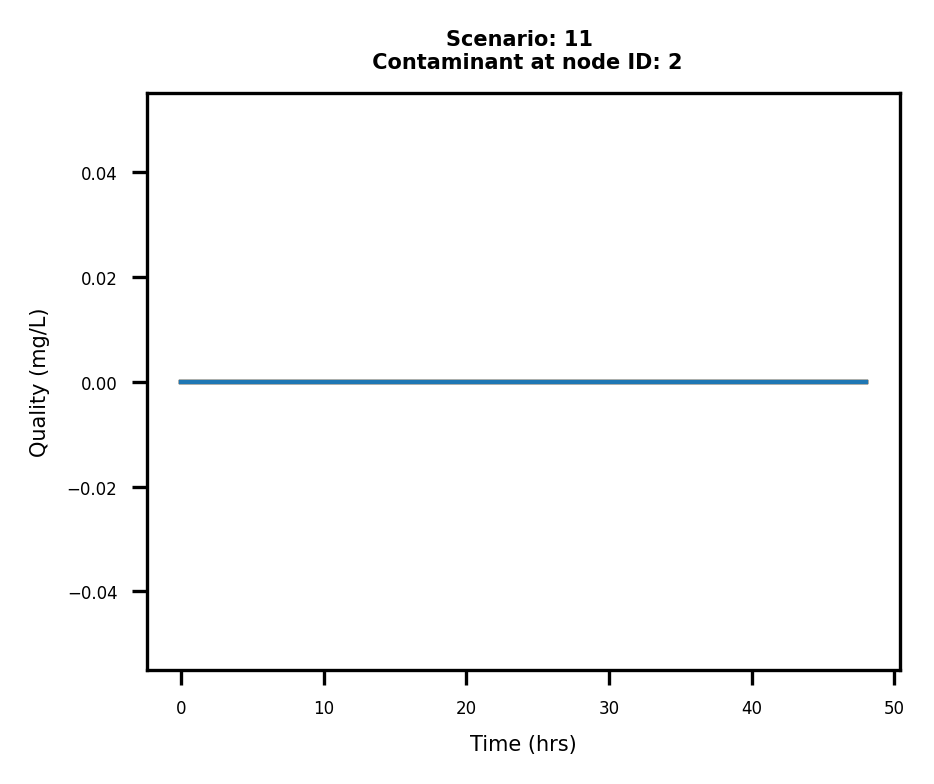

In [4]:
#  Plot Quality VS Time
for i in d.getNodeIndex():
    d.plot_ts(Y=CN[i], title=f'Scenario: {str(i)} \n Contaminant at node ID: {d.getNodeNameID(i)}',
              xlabel='Time (hrs)', ylabel='Quality (mg/L)', color=None, marker=None)

In [5]:
# Unload library
d.unload()

Close toolkit for the input file "Net1". EPANET Toolkit is unloaded.

